# Interpolation 2

**Goal:** Start trying out some of the conditional neural density estimators that work for *one* variable.
- HCNAF
- conditional UMNN
- Mixture Density Networks(?)

And then after these experiments, hopefully I'll be able to decide where I should move on to *more variables* or different types of loss functions.

Also - for this notebook, I'll want to train with $m_hh^{cor,2} = m_{hh} - m_{h1} - m_{h2} + 250$.


In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d
from scipy.stats import norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2

import torch
from torch import nn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in the dataset

In [2]:
nSelectedJets = 5

subDir = 'data_16_PFlow-MAY2019'
if nSelectedJets != 4:
    subDir += f'-{nSelectedJets}jets'
    
trigger ='2016_triggers'

fDir = f"../data/{subDir}/"

tag = '_NNT_HCs'
fout = f"{fDir}df_f_0.22{tag}.h5"

df = pd.read_hdf(fout,key='df')

Define the fit var of interest.

In [3]:
df['m_hh_cor2'] = df['m_hh'] - df['m_h1'] - df['m_h2'] + 250
df['log_m_hh_cor2'] = np.log(df['m_hh'] - df['m_h1'] - df['m_h2'])

To be consistent with the experiments in my previous notebook, I am just going to consider a zoomed version of the massplane.

In [21]:
mh2_edges = np.linspace(116-45,116+45,19)
mh1_edges = np.linspace(126-45,126+45,19) 

In [5]:
mh1_mask = (df.m_h1 > 126-45) & (df.m_h1 < 126+45)
mh2_mask = (df.m_h2 > 116-45) & (df.m_h2 < 116+45)

df['SR'] = (np.sqrt((10*(df.m_h1-120)/df.m_h1)**2+(10*(df.m_h2-110)/df.m_h1)**2) < 1.6)
zoom_mask = mh1_mask & mh2_mask & (df.ntag==2) & ~df.SR

In [79]:
X = df.loc[zoom_mask,['m_h1','m_h2','log_m_hh_cor2']]
#Y = df.loc[zoom_mask,[]].values

s = StandardScaler()
X_norm = s.fit_transform(X)

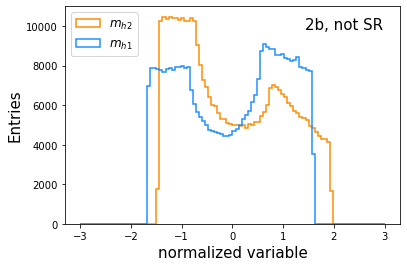

In [8]:
plt.hist(X_norm[:,:2],100,(-3,3),histtype='step',label=['$m_{h1}$','$m_{h2}$'],
         color=['dodgerblue','darkorange'],linewidth=1.5)
plt.xlabel('normalized variable',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(fontsize=12,loc='upper left')

ax = plt.gca()
plt.text(.95,.95,"2b, not SR",ha='right',va='top',transform=ax.transAxes,fontsize=15)

plt.savefig('figures/interp2/preprocessed_mh12.pdf',bbox_inches='tight')
plt.show()

In [9]:
X_norm.shape

(377417, 3)

Since this is a reasonably small training dataset - will I want to do **K-fold cross validation**?

In [11]:
N = X_norm.shape[0]
ix = np.arange(N)

np.random.seed(10)
np.random.shuffle(ix)

N_tr = np.floor(.4*N).astype(int)
N_val = np.floor(.5*N).astype(int)

ix_tr = ix[:N_tr]
ix_val = ix[N_tr:N_val]
ix_te = ix[N_val:]

In [12]:
X_tr = torch.from_numpy(X_norm[ix_tr,:2]).float()
Y_tr = torch.from_numpy(X_norm[ix_tr,-1]).float()

X_val = torch.from_numpy(X_norm[ix_val,:2]).float()
Y_val = torch.from_numpy(X_norm[ix_val,-1]).float()

X_te = torch.from_numpy(X_norm[ix_te,:2]).float()
Y_te = torch.from_numpy(X_norm[ix_te,-1]).float()

## Mixture Density Network

I thought it might be nice to do this experiment first b/c it seems like the most natural way to extend my previous set of studies with Gaussian fits.
- I could start of with just modelling a single mode, 
- Given the predicted $\mu$, $\sigma$ for all the variables of interest, I can easily generate a prediction.


### Setup the model


Let's start off w/ a simple NN model with 1 mode, and one hidden layer with 50 units.


In [26]:
D_in = 2
H = 25
D_out = 2 # one mode: predicting mean and variance for each point

mdn = nn.Sequential(nn.Linear(D_in, H),
                    nn.ReLU(),
                    nn.Linear(H,D_out))

### Train the model

**I should remember to put in functionality to put the models on the GPU!!**

Maybe just to make sure that I set everything up correctly - I should try to do some toy density estimation task?

Like estimate a Gaussian that I already know?

In [28]:
learning_rate = 1e-4
opt = torch.optim.Adam(mdn.parameters(),lr=learning_rate)

In [84]:
subDir = f'mdn_{H}_lr_{learning_rate}'
subDir

'mdn_25_lr_0.0001'

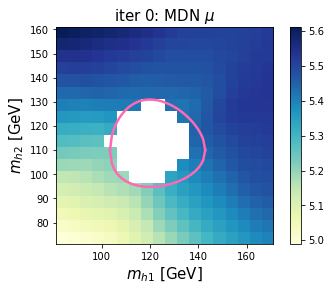

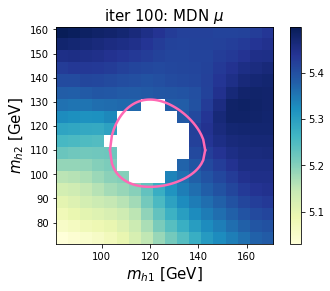

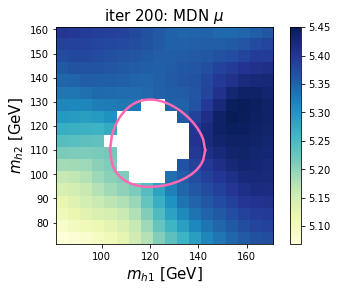

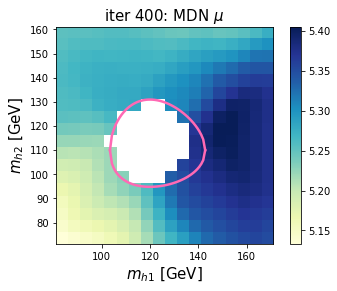

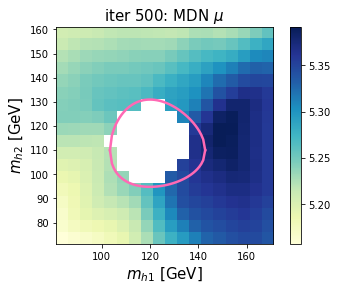

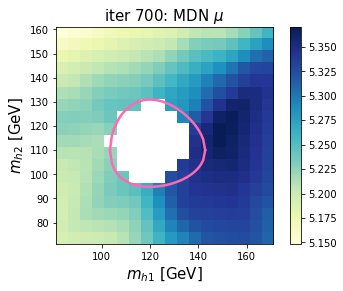

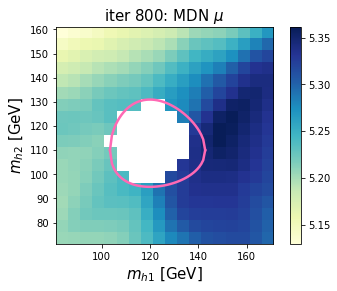

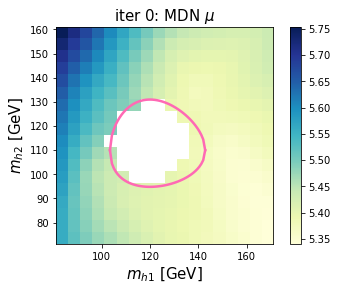

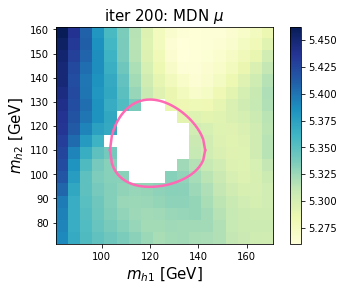

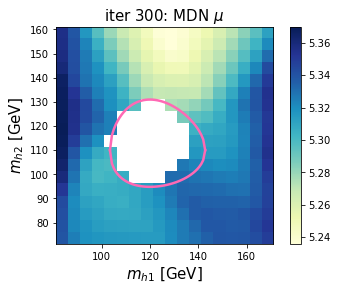

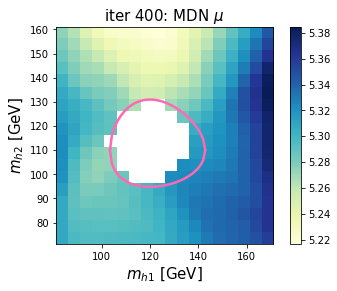

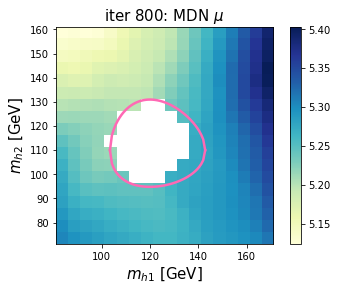

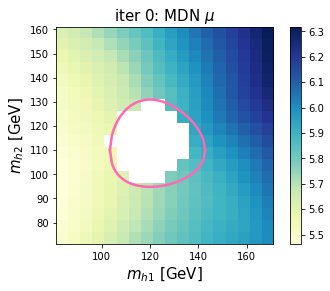

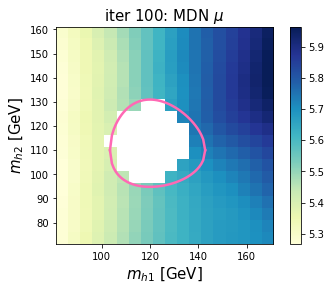

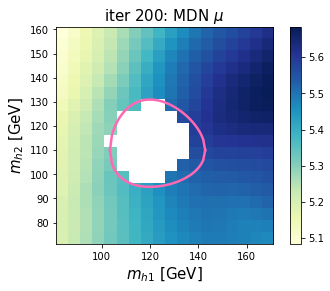

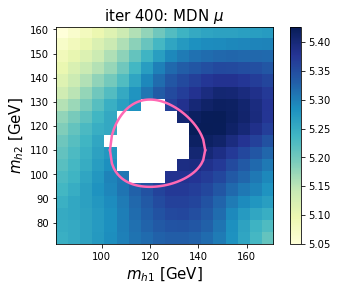

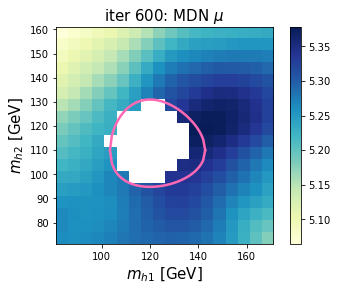

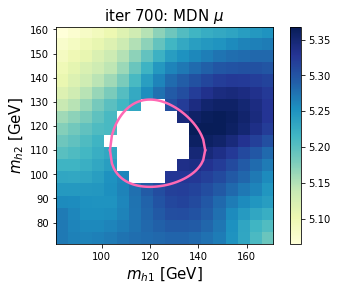

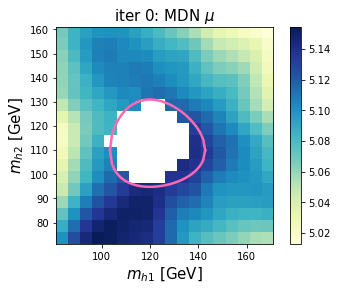

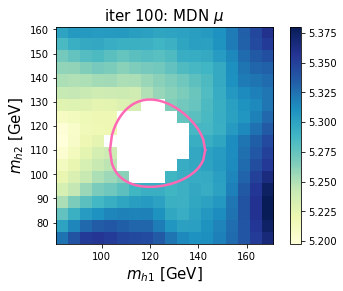

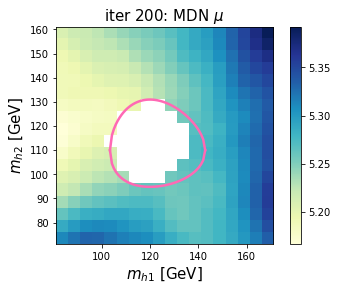

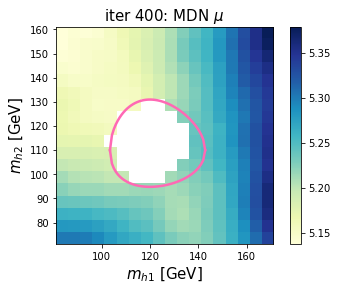

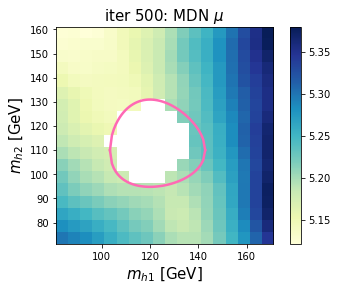

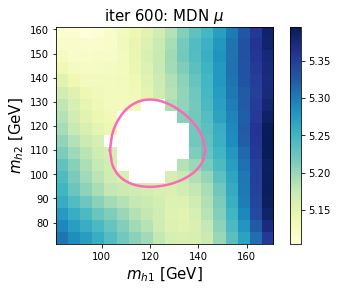

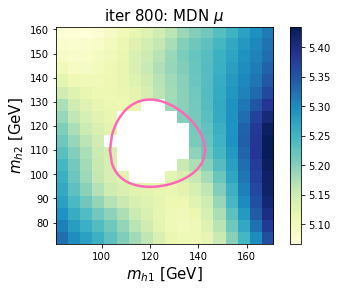

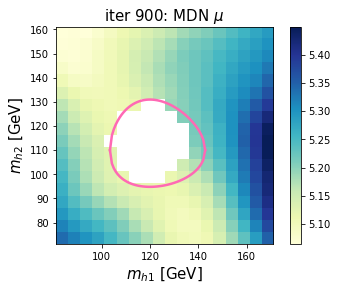

In [88]:
H_dims = [25,50,100,200]

train_loss = {H:[] for H in H_dims}
val_loss   = {H:[] for H in H_dims}

for H in H_dims:
    
    # Define a model
    mdn = nn.Sequential(nn.Linear(D_in, H),
                        nn.ReLU(),
                        nn.Linear(H,D_out))
    
    # Define an optimizer
    opt = torch.optim.Adam(mdn.parameters(),lr=learning_rate)
    
    subDir = f'mdn_{H}_lr_{learning_rate}'
    figDir = f'figures/interp2/{subDir}'
    if not os.path.exists(figDir): 
        os.mkdir(figDir)
    
    for t in range(1000):

        # Zero our the gradients
        opt.zero_grad()

        mdn.train()
        out = mdn(X_tr)
        mus, log_sigmas = out[:,0], out[:,1]

        #mus,log_sigmas = torch.split(out,1,dim=1)
        # Enforce non-negativity constraint for the sigmas
        sigmas = torch.exp(log_sigmas)

        exponent = -0.5*torch.pow(((Y_tr - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)

        train_loss[H].append(loss.item())
        loss.backward()
        opt.step()

        if t%100 == 0:

            z,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'].values[ix_tr],
                                          df.loc[zoom_mask,'m_h2'].values[ix_tr],
                                          s.mean_[-1]+s.scale_[-1]*(mus.detach().numpy().squeeze()),
                                          bins=[mh1_edges,mh2_edges])

            plt.imshow(z[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
            plt.colorbar()
            plt.title(f'iter {t}: MDN $\mu$',fontsize=15)

            plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
            plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

            plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
            plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

            plt.savefig(f'{figDir}/pred_mu_tr_iter{t}.pdf')
            
            plt.show()

        # Compute the validation loss
        mdn.eval()
        out = mdn(X_val)
        mus, log_sigmas = out[:,0], out[:,1]
        # Enforce non-negativity constraint for the sigmas
        sigmas = torch.exp(log_sigmas)

        exponent = -0.5*torch.pow(((Y_val - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)
        val_loss[H].append(loss.item())

    # Save the weights
        

In [113]:
i0tr_true,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'].values[ix_tr],
                                   df.loc[zoom_mask,'m_h2'].values[ix_tr],
                                   s.mean_[-1]+Y_tr*s.scale_[-1],
                                   bins=[mh1_edges,mh2_edges])

plt.imshow(z_true.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=5.15,vmax=5.5)
plt.colorbar()
plt.title(f'true values',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.show()

In [114]:
i0_true,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'], df.loc[zoom_mask,'m_h2'],
                                    df.loc[zoom_mask,'log_m_hh_cor2'],bins=[mh1_edges,mh2_edges])

plt.imshow(z_true.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=5.15,vmax=5.5)
plt.colorbar()
plt.title(f'true $\mu$s',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.show()

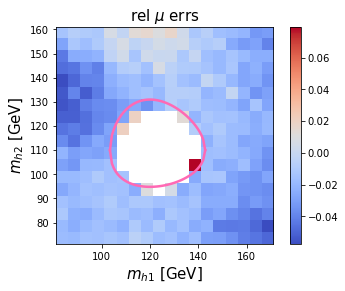

In [112]:
plt.imshow(((z-z_true)/z_true).T[::-1],cmap='coolwarm',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
plt.colorbar()
plt.title(f'rel $\mu$ errs',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.show()

I should add validation loss as well - and tinker, etc.

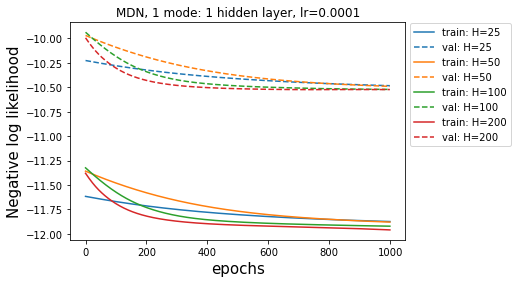

In [98]:
for i, H in enumerate(H_dims):
    plt.plot(train_loss[H],color=f'C{i}',label=f'train: H={H}')
    plt.plot(val_loss[H],color=f'C{i}',linestyle='--',label=f'val: H={H}')
plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15)
plt.legend(bbox_to_anchor=(1,1.02))
plt.title(f'MDN, 1 mode: 1 hidden layer, lr={learning_rate}')
plt.savefig('figures/interp2/nll_vary_nHidden.pdf',bbox_inches='tight')
plt.show()

Ok - either need to increase the lr, or train for longer?

Let's try to get some diagnostic plots together!

**Evaluation of the $\mu$ and $\sigma$s**
- This might involve some finangling between the training and test sets as well.


So I think the fastest way to code this up will be to use the `binned_statistic_2d` function.

In [68]:
pred = mdn(X_te)
mus,log_sigmas = torch.split(pred,1,dim=1)

In [69]:
pred.shape

torch.Size([188709, 2])

In [70]:
df.loc[zoom_mask,'m_h1'].values[ix_te].shape

(188709,)

In [71]:
z,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'].values[ix_te],
                              df.loc[zoom_mask,'m_h2'].values[ix_te],
                              mus[:,0].detach().numpy(),
                              bins=[mh1_edges,mh2_edges])

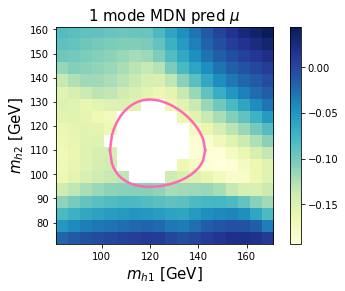

In [72]:
#fits[k][::-1]
plt.imshow(z[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
plt.colorbar()
plt.title('1 mode MDN pred $\mu$',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

#plt.savefig(f'figures/interp1/Gaussian_{m_hh}_18x18_{k}.pdf',bbox_inches='tight')

plt.show()

## New diagnostic

Ok, so it seems like right our of the box the modl is struggline to learn the parabaloid shape that I already was kind of thinking that the data should have, so should I do experiments to try to understand how hard it is to learn a parabaloid for a MDN?

Yeah, it'd probably be a reasonable place to start! And then at least I can can deconvolve effects.

In [115]:
len(X_tr)

150966

In [8]:
p0 = np.array([6.72850816e+00, -1.46482507e-02, -1.09444251e-02,  5.63961367e-05,
               5.39500030e-05,  1.99625493e-01,  4.61933788e-03,  4.12577094e-03,
               -1.93993513e-05, -2.03241643e-05])

In [14]:
F = np.vstack([np.ones_like(ix_tr), *X.values[ix_tr,:2].T, *X.values[ix_tr,:2].T**2])
F.shape

(5, 150966)

In [15]:
mu_toy    = np.dot(p0[:5],F)
sigma_toy = np.dot(p0[5:],F)

u = norm.rvs(loc=mu_toy, scale=sigma_toy)

In [16]:
Y_tr_toy = (u - s.mean_[-1]) / s.scale_[-1] 

Sanity check that the generated data look ok:

In [58]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(*X.values[ix_tr,:2].T,mu_toy,s=.1,c=mu_toy,cmap='YlGnBu')
ax.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_ylabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_zlabel('parabaloid predicted $\mu$',fontsize=15)

plt.savefig('figures/interp2/toy_mu_2b.png',bbox_inches='tight')
#plt.savefig('figures/interp2/toy_mu_2b.pdf',bbox_inches='tight')

plt.show()


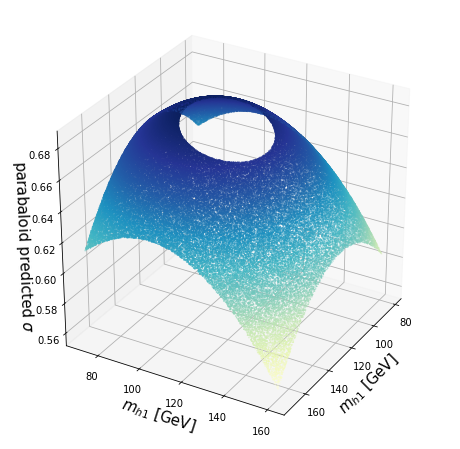

In [59]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(*X.values[ix_tr,:2].T,sigma_toy,s=.1,c=sigma_toy,cmap='YlGnBu')
ax.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_ylabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_zlabel('parabaloid predicted $\sigma$',fontsize=15)

ax.view_init(30, 30)

plt.savefig('figures/interp2/toy_sigma_2b.png',bbox_inches='tight')
#plt.savefig('figures/interp2/toy_sigma_2b.pdf',bbox_inches='tight')
plt.show()

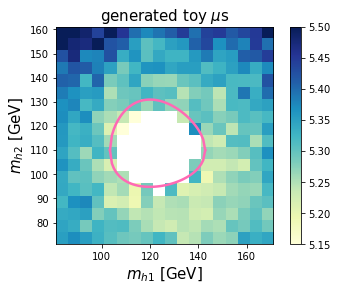

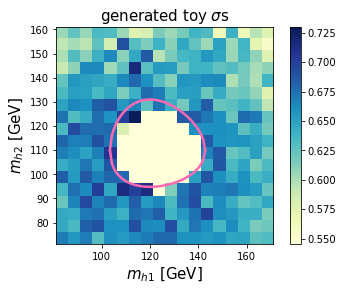

In [60]:
i0_toy,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'].values[ix_tr], 
                                   df.loc[zoom_mask,'m_h2'].values[ix_tr],
                                   u,bins=[mh1_edges,mh2_edges])

plt.imshow(i0_toy.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=5.15,vmax=5.5)
plt.colorbar()
plt.title(f'generated toy $\mu$s',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.savefig('figures/interp2/toy_mu_2b_2d.png',bbox_inches='tight')
plt.show()

plt.figure()
i1_toy,_,_,_ = binned_statistic_2d(df.loc[zoom_mask,'m_h1'].values[ix_tr], 
                                   df.loc[zoom_mask,'m_h2'].values[ix_tr],
                                   u,'std',bins=[mh1_edges,mh2_edges])

plt.imshow(i1_toy.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=0.545,vmax=0.73)
plt.colorbar()
plt.title(f'generated toy $\sigma$s',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.savefig('figures/interp2/toy_sigma_2b_2d.png',bbox_inches='tight')
plt.show()

Ok - yeah these look ok to start off with.

In [ ]:
# Define the true images for this problem

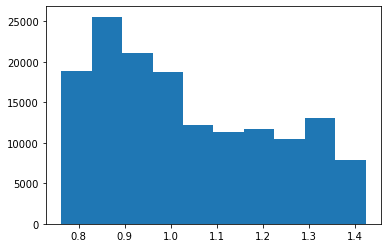

In [37]:
plt.hist(sigmas.detach().numpy())
plt.show()

In [42]:
1/s.scale_[-1]**2

2.3256834269173647

(array([37., 18., 36., 47., 57., 62., 19., 35.,  8.,  5.]),
 array([0.        , 0.00332778, 0.00665557, 0.00998335, 0.01331113,
        0.01663891, 0.0199667 , 0.02329448, 0.02662226, 0.02995005,
        0.03327783]),
 <a list of 10 Patch objects>)

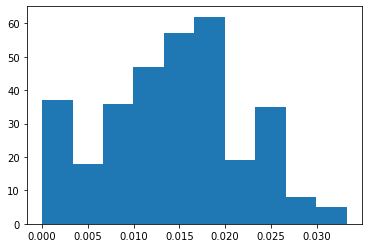

In [43]:
plt.hist(i1.flatten()/s.scale_[-1]**2)

In [72]:
plt.hist(i1.flatten(),100)
plt.show()

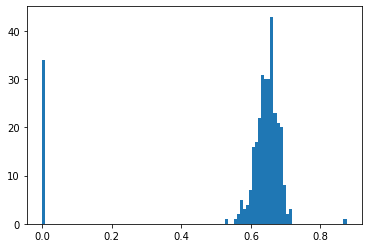

In [73]:
plt.hist(i1_toy.flatten(),100)
plt.show()

In [74]:
def evalErrorsOneMode(df,mask,ix,i0_true,i1_true,mus,sigmas,s,figDir='',tag=''):
    '''
    Plot the predicted mus and sigmas of the one mode MDN.
    
    Inputs:
    - df:
    - ix:
    - i0_true:
    - i1_true:
    - mus:
    - sigmas:
    - s:
    - figDir:
    - tag:
    '''
    fig, axs = plt.subplots(2,2,figsize=(11,10))

    # mu
    i0,_,_,_ = binned_statistic_2d(df.loc[mask,'m_h1'].values[ix],
                                  df.loc[mask,'m_h2'].values[ix],
                                  s.mean_[-1]+s.scale_[-1]*(mus.detach().numpy().squeeze()),
                                  bins=[mh1_edges,mh2_edges])

    p = axs[0,0].imshow(i0.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
    fig.colorbar(p,ax=axs[0,0])
    axs[0,0].set_title(f'iter {t}: MDN $\mu$',fontsize=15)

    axs[0,0].set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
    axs[0,0].set_ylabel('$m_{h2}$ [GeV]',fontsize=15)

    axs[0,0].plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
    axs[0,0].plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

    # rel err mu
    p = axs[0,1].imshow(100*((i0-i0_true)/i0_true).T[::-1],cmap='coolwarm',
                        extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
    fig.colorbar(p,ax=axs[0,1],label='% err')
    axs[0,1].set_title(f'rel $\mu$ errs',fontsize=15)

    axs[0,1].set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
    axs[0,1].set_ylabel('$m_{h2}$ [GeV]',fontsize=15)

    axs[0,1].plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
    axs[0,1].plot(SR_x, SR_y2,'hotpink',linewidth=2.5)


    # sigma
    i1,_,_,_ = binned_statistic_2d(df.loc[mask,'m_h1'].values[ix],
                                   df.loc[mask,'m_h2'].values[ix],
                                   s.scale_[-1]*(sigmas.detach().numpy().squeeze()),
                                   'std',bins=[mh1_edges,mh2_edges])

    p = axs[1,0].imshow(i1.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
    fig.colorbar(p,ax=axs[1,0])
    axs[1,0].set_title(f'iter {t}: MDN $\sigma$')

    axs[1,0].set_xlabel('$m_{h1}$ [GeV]')
    axs[1,0].set_ylabel('$m_{h2}$ [GeV]')

    axs[1,0].plot(SR_x, SR_y1,'hotpink',linewidth=1.5)
    axs[1,0].plot(SR_x, SR_y2,'hotpink',linewidth=1.5)

    # rel err sigma
    p = axs[1,1].imshow(100*((i1-i1_true)/i1_true).T[::-1],cmap='coolwarm',
                        extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]])
    fig.colorbar(p,ax=axs[1,1],label='% err')
    axs[1,1].set_title(f'rel $\sigma$ errs',fontsize=15)

    axs[1,1].set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
    axs[1,1].set_ylabel('$m_{h2}$ [GeV]',fontsize=15)

    axs[1,1].plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
    axs[1,1].plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

    if len(figDir) > 0:
        plt.savefig(f'{figDir}/pred_mu_sigma_errs{tag}_iter{t}.pdf',bbox_inches='tight')

    plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


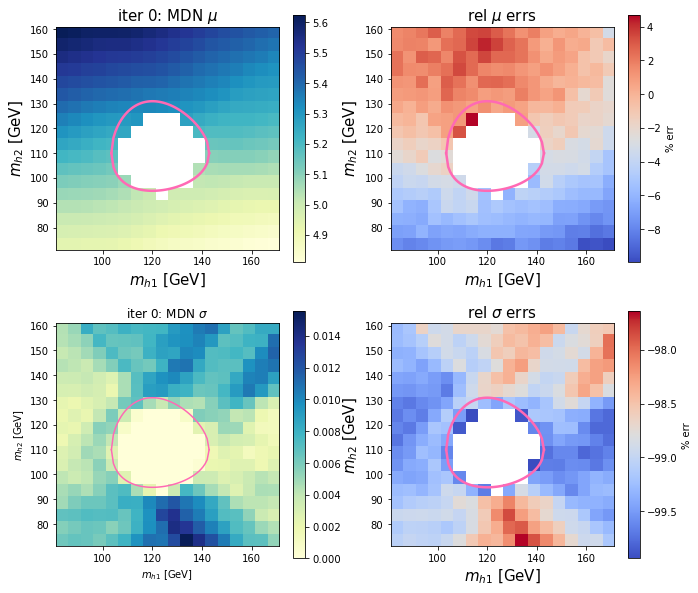

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


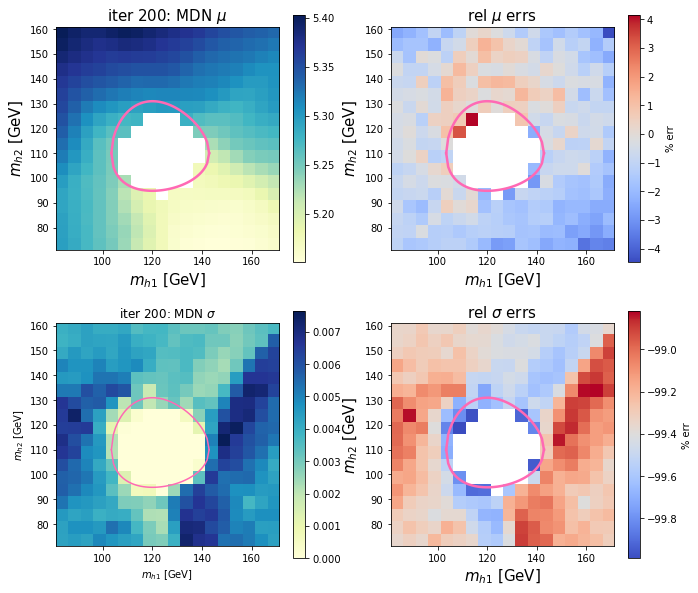

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


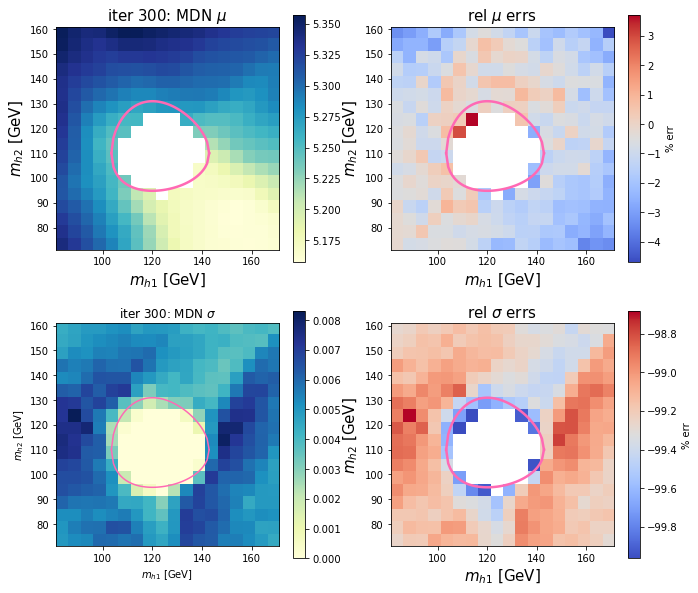

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


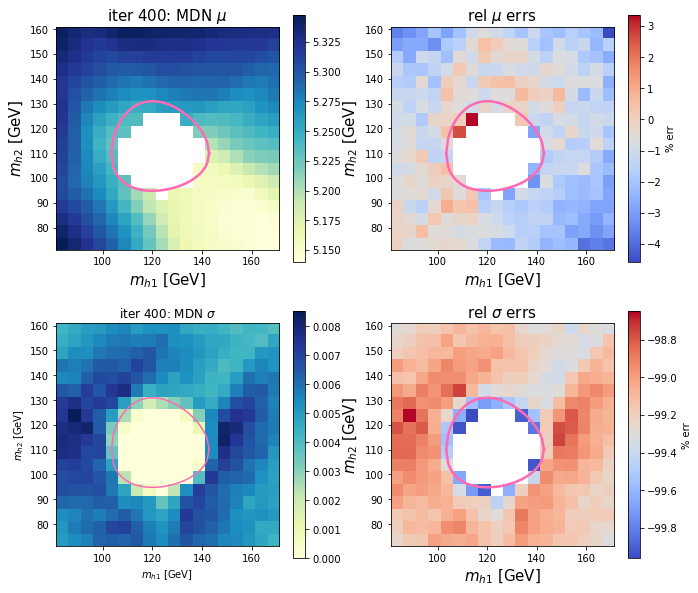

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


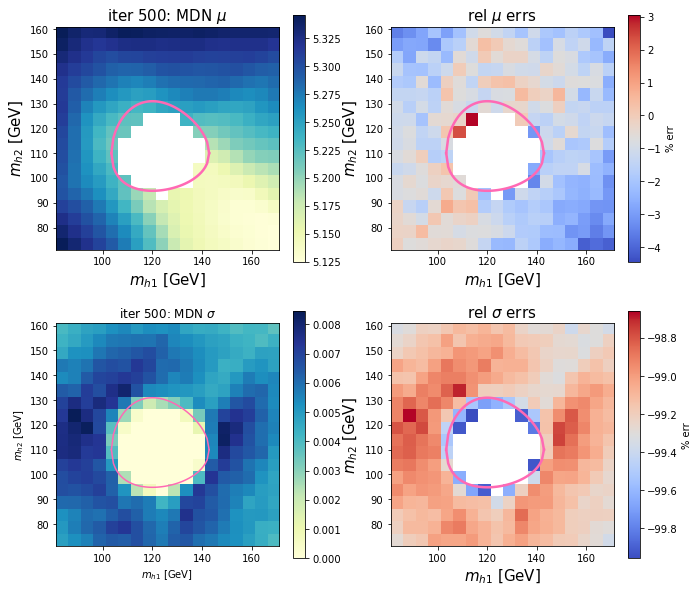

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


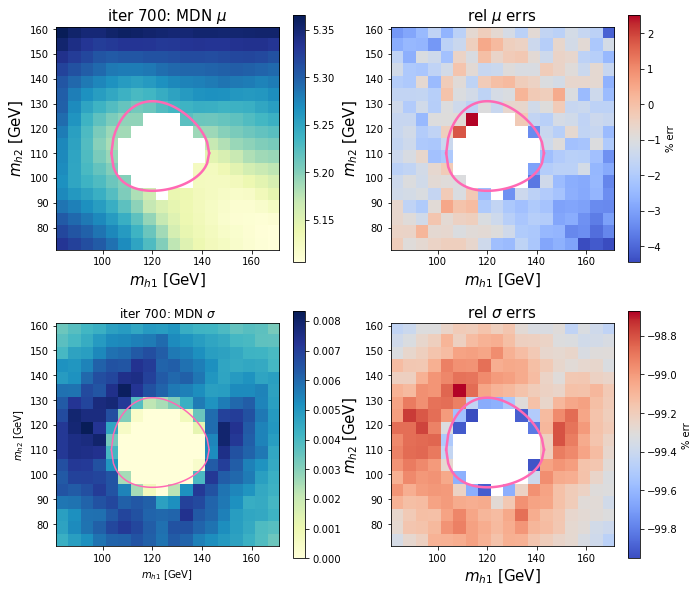

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


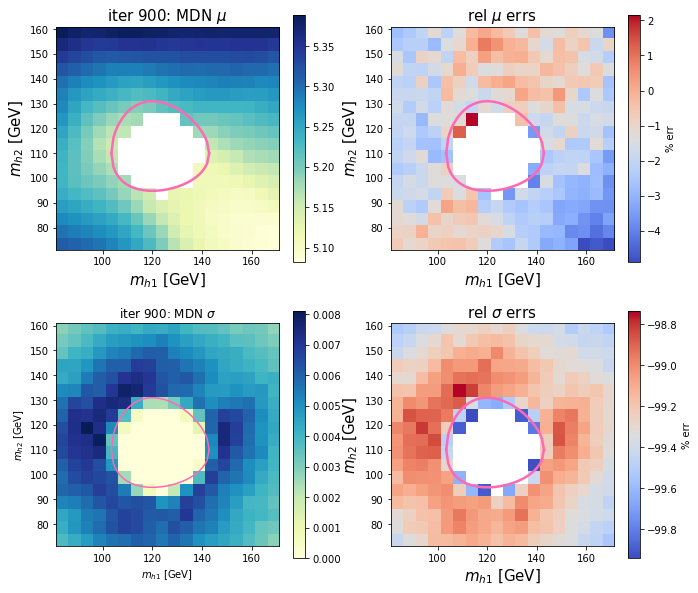

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


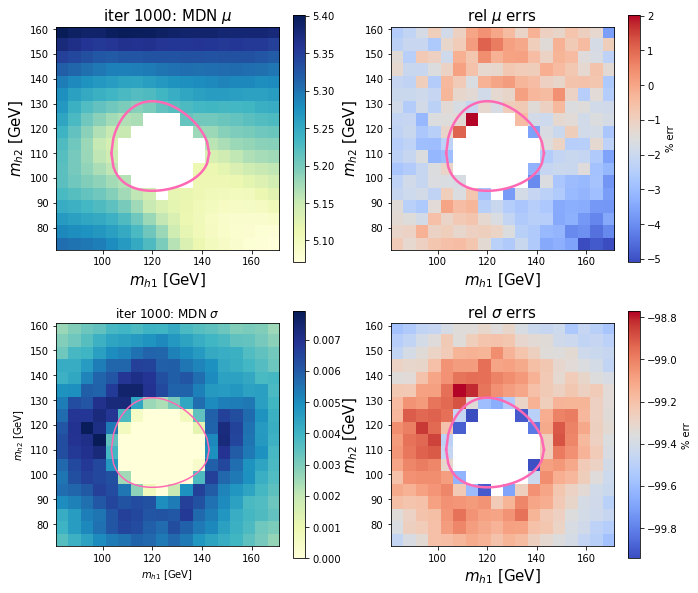

In [56]:
H_dims = [100]

train_loss = {H:[] for H in H_dims}
val_loss   = {H:[] for H in H_dims}

for H in H_dims:
    
    # Define a model
    mdn = nn.Sequential(nn.Linear(D_in, H),
                        nn.ReLU(),
                        nn.Linear(H,D_out))
    
    # Define an optimizer
    opt = torch.optim.Adam(mdn.parameters(),lr=learning_rate)
    
    subDir = f'toy_mdn_{H}_lr_{learning_rate}'
    figDir = f'figures/interp2/{subDir}'
    if not os.path.exists(figDir): 
        os.mkdir(figDir)
    
    for t in range(1001):

        # Zero our the gradients
        opt.zero_grad()

        mdn.train()
        out = mdn(X_tr)
        mus, log_sigmas = out[:,0], out[:,1]
        sigmas = torch.exp(log_sigmas) # non-negativity constraint

        exponent = -0.5*torch.pow(((Y_tr - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)

        train_loss[H].append(loss.item())
        loss.backward()
        opt.step()

        if t%100 == 0:
            evalErrorsOneMode(df,zoom_mask,ix_tr,i0_toy,i1_toy,mus,sigmas,s,figDir=figDir)
            
        # Compute the validation loss
        mdn.eval()
        out = mdn(X_val)
        mus, log_sigmas = out[:,0], out[:,1]
        # Enforce non-negativity constraint for the sigmas
        sigmas = torch.exp(log_sigmas)

        exponent = -0.5*torch.pow(((Y_val - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)
        val_loss[H].append(loss.item())

    # Save the weights
        

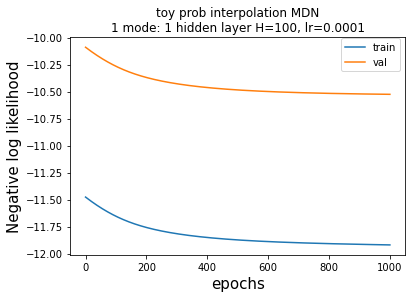

In [70]:
plt.plot(train_loss[H],label=f'train')
plt.plot(val_loss[H],label=f'val')
plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15)
plt.legend(bbox_to_anchor=(1,1.02))
plt.title(f'toy prob interpolation MDN\n1 mode: 1 hidden layer H={H}, lr={learning_rate}')
plt.savefig(f'figures/interp2/{subDir}/nll_vary_nHidden.pdf',bbox_inches='tight')
plt.show()

The errors on $\sigma$ are *huge*... why is this?

Should I make a pixel plot to evaluate the model? (Seems like a reasonalbe idea.)

### Next: Try training the toy problem without the hole.

**Preprocess a *new* dataset without a hole**

In [78]:
mask_all = mh1_mask & mh2_mask & (df.ntag==2)

X1 = df.loc[mask_all,['m_h1','m_h2','log_m_hh_cor2']]

s1 = StandardScaler()
X1_norm = s1.fit_transform(X1)

# train / test split
N = X1_norm.shape[0]
i1 = np.arange(N)

np.random.seed(10)
np.random.shuffle(i1)

N_tr = np.floor(.4*N).astype(int)
N_val = np.floor(.5*N).astype(int)

i1_tr = i1[:N_tr]
i1_val = i1[N_tr:N_val]
i1_te = i1[N_val:]

# torch  tensors
X1_tr = torch.from_numpy(X1_norm[i1_tr,:2]).float()
Y1_tr = torch.from_numpy(X1_norm[i1_tr,-1]).float()

X1_val = torch.from_numpy(X1_norm[i1_val,:2]).float()
Y1_val = torch.from_numpy(X1_norm[i1_val,-1]).float()

X1_te = torch.from_numpy(X1_norm[i1_te,:2]).float()
Y1_te = torch.from_numpy(X1_norm[i1_te,-1]).float()

Generate the "toy" data points.

In [84]:
F1 = np.vstack([np.ones_like(i1_tr), *X1.values[i1_tr,:2].T, *X1.values[i1_tr,:2].T**2])

mu_noHole    = np.dot(p0[:5],F1)
sigma_noHole = np.dot(p0[5:],F1)

u1 = norm.rvs(loc=mu_noHole, scale=sigma_noHole)

Y1_noHole = (u1 - s1.mean_[-1]) / s1.scale_[-1] 

Get the true plots.

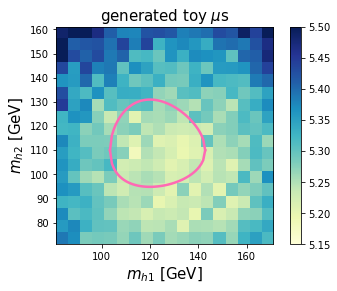

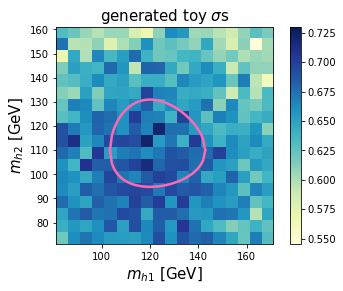

In [85]:
i0_noHole,_,_,_ = binned_statistic_2d(df.loc[mask_all,'m_h1'].values[i1_tr], 
                                   df.loc[mask_all,'m_h2'].values[i1_tr],
                                   u1,bins=[mh1_edges,mh2_edges])

plt.imshow(i0_noHole.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=5.15,vmax=5.5)
plt.colorbar()
plt.title(f'generated toy $\mu$s',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.savefig('figures/interp2/noHole_mu_2b_2d.png',bbox_inches='tight')
plt.show()

plt.figure()
i1_noHole,_,_,_ = binned_statistic_2d(df.loc[mask_all,'m_h1'].values[i1_tr], 
                                      df.loc[mask_all,'m_h2'].values[i1_tr],
                                      u1,'std',bins=[mh1_edges,mh2_edges])

plt.imshow(i1_noHole.T[::-1],cmap='YlGnBu',extent=[*mh1_edges[[0,-1]],*mh2_edges[[0,-1]]],
           vmin=0.545,vmax=0.73)
plt.colorbar()
plt.title(f'generated toy $\sigma$s',fontsize=15)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=15)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=15)

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.savefig('figures/interp2/noHole_sigma_2b_2d.png',bbox_inches='tight')
plt.show()

**Train a model**

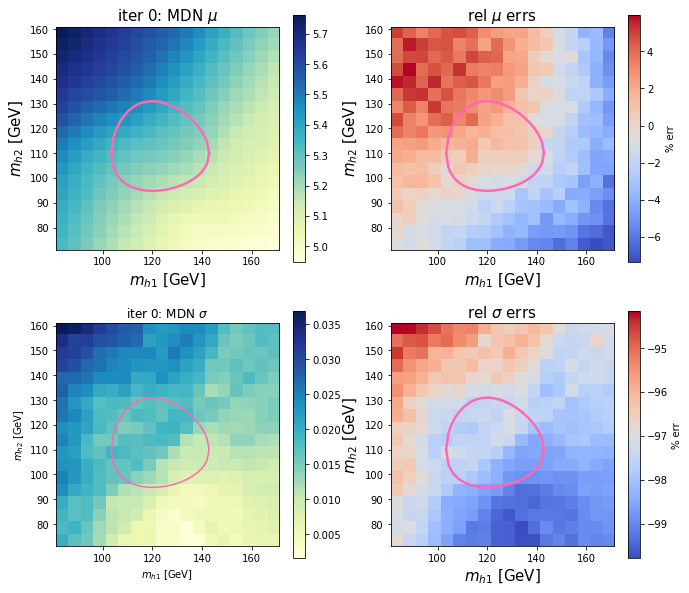

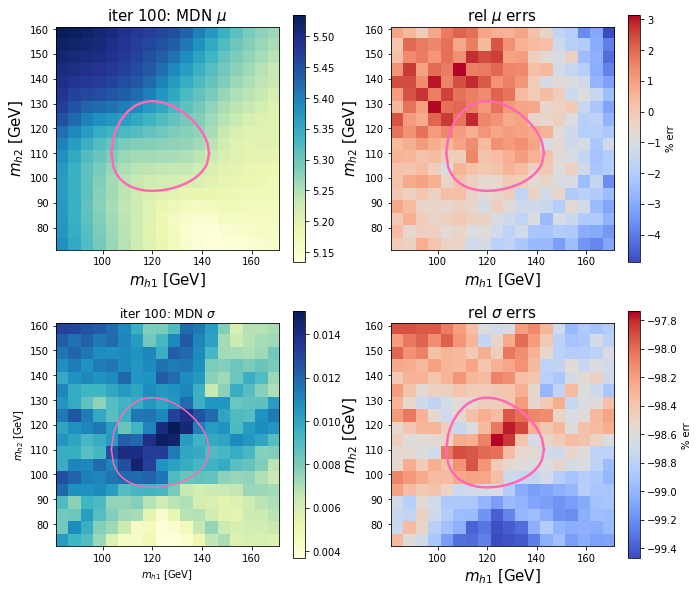

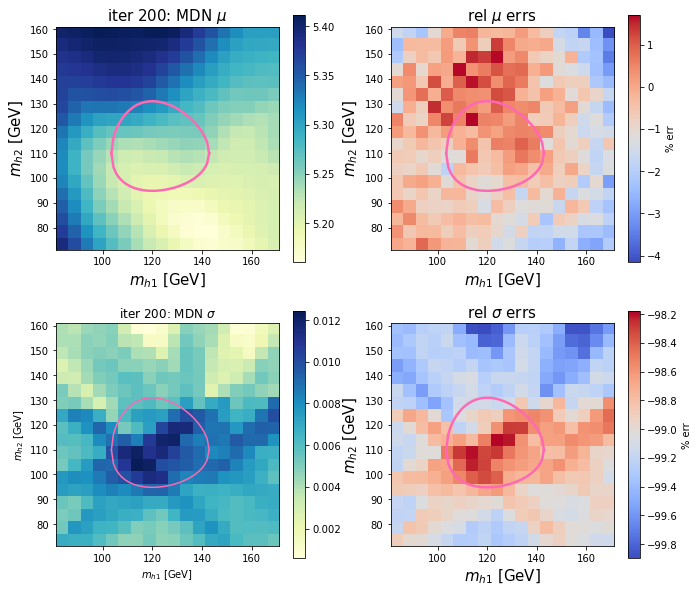

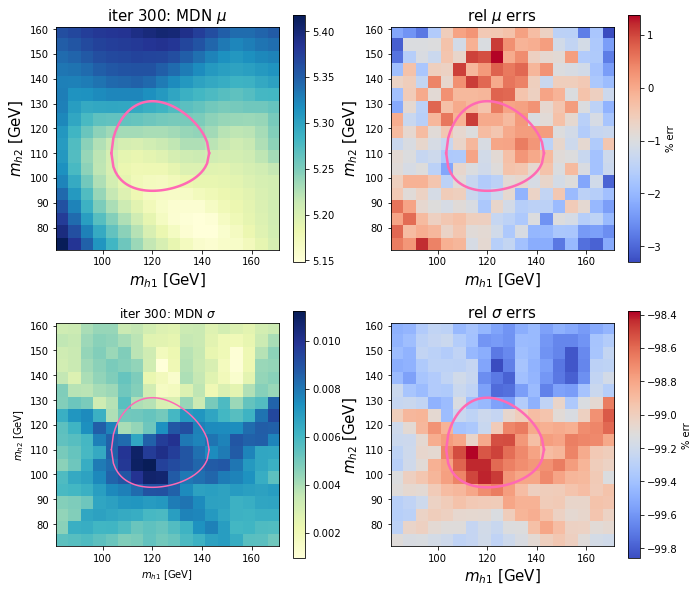

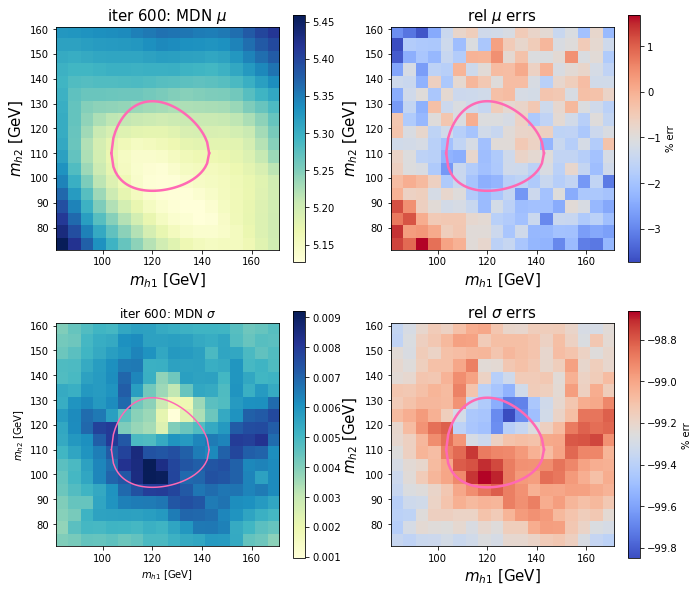

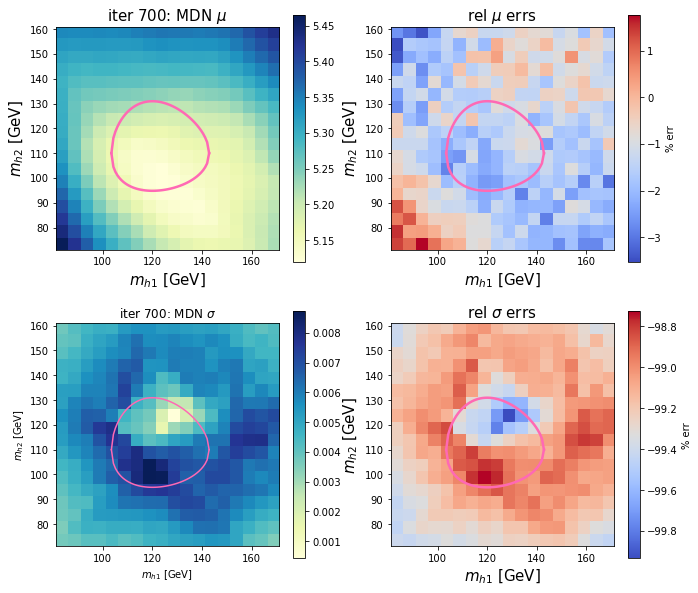

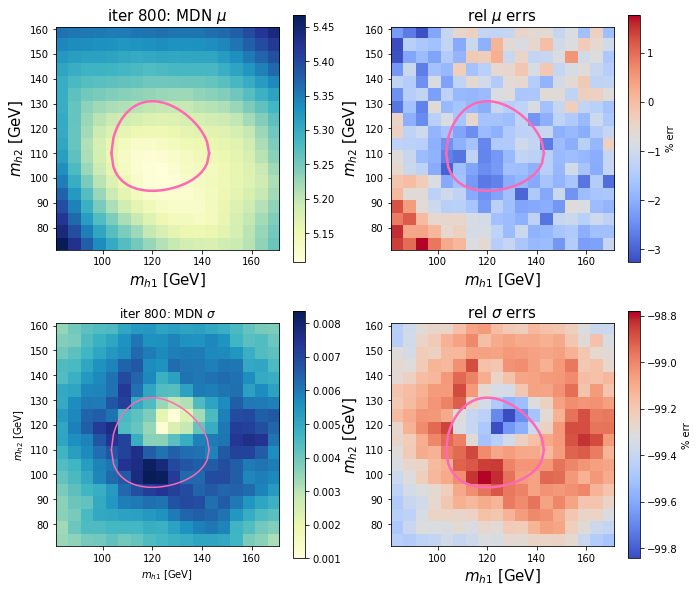

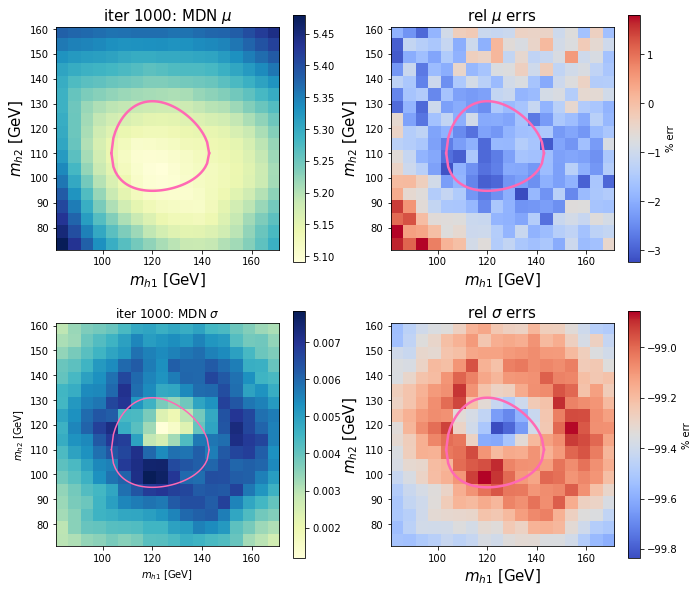

In [87]:
train_loss1 = {H:[] for H in H_dims}
val_loss1   = {H:[] for H in H_dims}

for H in H_dims:
    
    # Define a model
    mdn1 = nn.Sequential(nn.Linear(D_in, H),
                         nn.ReLU(),
                         nn.Linear(H,D_out))
    
    # Define an optimizer
    opt1 = torch.optim.Adam(mdn1.parameters(),lr=learning_rate)
    
    subDir = f'toy_mdn_{H}_lr_{learning_rate}_noHole'
    figDir = f'figures/interp2/{subDir}'
    if not os.path.exists(figDir): 
        os.mkdir(figDir)
    
    for t in range(1001):

        # Zero our the gradients
        opt1.zero_grad()

        mdn1.train()
        out = mdn1(X1_tr)
        mus, log_sigmas = out[:,0], out[:,1]
        sigmas = torch.exp(log_sigmas) # non-negativity constraint

        exponent = -0.5*torch.pow(((Y1_tr - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)

        train_loss1[H].append(loss.item())
        loss.backward()
        opt1.step()

        if t%100 == 0:
            evalErrorsOneMode(df,mask_all,i1_tr,i0_noHole,i1_noHole,mus,sigmas,s1,figDir=figDir)
            
        # Compute the validation loss
        mdn1.eval()
        out = mdn1(X1_val)
        mus, log_sigmas = out[:,0], out[:,1]
        # Enforce non-negativity constraint for the sigmas
        sigmas = torch.exp(log_sigmas)

        exponent = -0.5*torch.pow(((Y1_val - mus) / sigmas),2) - log_sigmas
        loss = - torch.logsumexp(exponent,dim=0)
        val_loss1[H].append(loss.item())

    # Save the weights
        

**Evaluate the results**

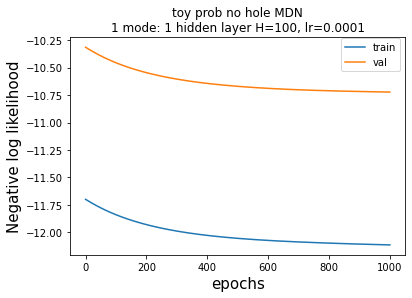

In [89]:
plt.plot(train_loss1[H],label=f'train')
plt.plot(val_loss1[H],label=f'val')
plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15)
plt.legend(bbox_to_anchor=(1,1.02))
plt.title(f'toy prob no hole MDN\n1 mode: 1 hidden layer H={H}, lr={learning_rate}')
plt.savefig(f'figures/interp2/{subDir}/nll_vary_nHidden.pdf',bbox_inches='tight')
plt.show()

### Evaluate the results
- I should split the training dataset into two so that I can compare both how well it's reproducing the data *and* how well it's generalizing.
- I think it would be nice to make "test SRs" and see how some sort of reconstruction error varies based on the circle definition, and then I can compare *interpolation* error, and maybe look at the *extrapolation* performance of the model as well?
- Then I should maybe make of list for hyperparameters I want to test, and if I want to get more or less complex? (Probably I'll want to set up slurm trainings for this.)
- It would be interesting if I could define a very minimal model that could reproduce the Gaussian datapoints example?

- Do I want to do Real-NVPs next - or scale up to multiple variables?
- Or should I try to incorporated "learning to flow" in the loss function?

## HCNAF